**TL;DR.** Using a synthetic dataset of simple arithmetic problems, I identified a single activation direction D in a middle layer of an LLM that causally controls its commitment to answering “Yes” versus “No”. This direction is not merely separating correct from incorrect arithmetic reasoning: shows symptoms of generalizability to arithmetic, counting, geography, logic, physics, tautologies and biases the model toward affirmation or rejection (even on trivial, high-confidence facts). Notably, even when the model already agrees with a statement, pushing along this direction further increases its confidence, indicating that it isn't simply adjustment to move from the region it doesn't trust to one it trusts. Applying this intervention aD during explicit reasoning shows that correct reasoning can still occur in the model’s thoughts (if scale a isn't too big).

PS. The initial motivation drew inspiration from “**inception**” effects in humans, where plausible but incorrect reasoning can induce confident commitment under constrained validation (i.e. reasoning in case of LLM). But it seems I failed to find neurons in LLM responsibile for sufficiently specific idea.

# Model Loading

In [1]:
!pip install -q transformers accelerate
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 29.9 MB/s eta 0:00:00


In [2]:
import string
import json
from collections import Counter
import random
import math
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import logging
logging.set_verbosity_error()

In [3]:
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.config.pad_token_id = model.config.eos_token_id # for warnings
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

2026-01-05 19:28:06.248571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767641286.674473      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767641286.798998      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767641287.835606      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767641287.835632      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767641287.835635      24 computation_placer.cc:177] computation placer alr

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm

# Some functools

In [4]:
yes_id = tokenizer.encode("Yes", add_special_tokens=False)[0]
no_id  = tokenizer.encode("No",  add_special_tokens=False)[0]

In [5]:
ONE_SHOT = """QUESTION:
1+1=2?

THOUGHTS:
Arithmetical problem.
DONE.


ANSWER:
Yes"""

In [6]:
def build_answer_prompt(
    question: str, 
    thoughts: str
) -> str:
    return f"""{ONE_SHOT}

QUESTION:
{question}

THOUGHTS:
{thoughts}
DONE.

ANSWER:
"""

In [7]:
def build_thoughts_prompt(
    question: str, 
    thoughts: str)-> str:
    return f"""QUESTION:
{question}

CURRENT THOUGHTS:
{thoughts}

THOUGHTS CONTINUATION (no problem statement repetition):
"""

In [8]:
def generate_thoughts(question, thoughts_so_far, max_new_tokens=64):
    prompt = build_thoughts_prompt(question, thoughts_so_far)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
        )
    new_ids = out[0][inputs["input_ids"].shape[1]:] # only generated part
    text = tokenizer.decode(new_ids, skip_special_tokens=True)
    return text.strip()

In [9]:
def get_stats(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        logits = model(**inputs).logits[:, -1, :]

    logit_yes = logits[0, yes_id]
    logit_no  = logits[0, no_id]

    abs_probs = F.softmax(logits[0], dim=0)
    p_yes_abs = abs_probs[yes_id].item()
    p_no_abs  = abs_probs[no_id].item()

    mass = p_yes_abs + p_no_abs

    if mass > 0:
        p_yes_cond = p_yes_abs / mass
        p_no_cond  = p_no_abs  / mass
    else:
        p_yes_cond = float("nan")
        p_no_cond  = float("nan")

    return {
        "margin": (logit_yes - logit_no).item(),
        "odds": math.exp((logit_yes - logit_no).item()),
        "p_yes_cond": p_yes_cond,
        "p_no_cond":  p_no_cond,
        "p_yes_abs": p_yes_abs,
        "p_no_abs":  p_no_abs,
        "mass_yesno": mass
    }

# PoC - toy problem around 2 + 2
May jnjected thoughts (as prompts) affect model's preferences at all?

*Here I hoped that injected to the prompt thoughts may work as thoughts and emotions in our brains...*

In [10]:
question = "2 + 2 = 0?"
print("Question:", question + "\n")
for t in [
    " ", "I'm tired.", "I'm excited.", "Problem on arithmetic.", "Modular arithmetic.", 
    "Modulo 4 arithmetic.", "Modulo 7 arithmetic.", "Modulo 4 arithmetic or standard arithmetic."
]:
    s = get_stats(build_answer_prompt(question=question, thoughts=t))
    print(f"Thoughts: *{t}* -->> Probs: P(Yes)={s['p_yes_cond']:.2f} P(No)={s['p_no_cond']:.2f}")

Question: 2 + 2 = 0?

Thoughts: * * -->> Probs: P(Yes)=0.03 P(No)=0.97
Thoughts: *I'm tired.* -->> Probs: P(Yes)=0.04 P(No)=0.96
Thoughts: *I'm excited.* -->> Probs: P(Yes)=0.05 P(No)=0.95
Thoughts: *Problem on arithmetic.* -->> Probs: P(Yes)=0.05 P(No)=0.95
Thoughts: *Modular arithmetic.* -->> Probs: P(Yes)=0.45 P(No)=0.55
Thoughts: *Modulo 4 arithmetic.* -->> Probs: P(Yes)=0.85 P(No)=0.15
Thoughts: *Modulo 7 arithmetic.* -->> Probs: P(Yes)=0.87 P(No)=0.13
Thoughts: *Modulo 4 arithmetic or standard arithmetic.* -->> Probs: P(Yes)=0.12 P(No)=0.88


# Search for good problem

The task should allow manipulation of the model and easy generation of synthetic data.

## Making it harder: problem around $E[f(X)] = f(E[X])$

In [11]:
question_on_expectation = "Expected value of X is 10. Does this mean that expected value of its square is 100?"
print("Question: ", question_on_expectation, "\n")
for t in [
    "",
    "Suppose X is constant, then X^2 is also constant and this constant is C * C = C^2. E[C^2] = C^2. 10^2=100.",
    "10 * 10 = 100.",
    "10*10=100. " * 7
]:
    s = get_stats(build_answer_prompt(question=question_on_expectation, thoughts=t))
    print(f"Thoughts: *{t}* -->> Probs: P(Yes)={s['p_yes_cond']:.2f} P(No)={s['p_no_cond']:.2f}")

Question:  Expected value of X is 10. Does this mean that expected value of its square is 100? 

Thoughts: ** -->> Probs: P(Yes)=0.00 P(No)=1.00
Thoughts: *Suppose X is constant, then X^2 is also constant and this constant is C * C = C^2. E[C^2] = C^2. 10^2=100.* -->> Probs: P(Yes)=0.53 P(No)=0.47
Thoughts: *10 * 10 = 100.* -->> Probs: P(Yes)=0.02 P(No)=0.98
Thoughts: *10*10=100. 10*10=100. 10*10=100. 10*10=100. 10*10=100. 10*10=100. 10*10=100. * -->> Probs: P(Yes)=0.00 P(No)=1.00


Unfortunately, this problem turned out to be hard for synthetic dataset generation and model prompting.

## Golded mean: around average speed

Later we will confirm that it is good choice. Model can be manipulated on this problem.

In [12]:
question_on_avg_speed = "The road has 500km. A car goes from A to B at 60 km/h and returns from B to A at 40 km/h. Will the trip take 10h?"
print("Question: ", question_on_avg_speed, "\n")
for t in ["", "Average of 60 and 40 is 50.", "Average of 60 and 40 is 50. 500/50 is 10."]:
    s = get_stats(build_answer_prompt(question=question_on_avg_speed, thoughts=t))
    print(f"Thoughts: *{t}* -->> Probs: P(Yes)={s['p_yes_cond']:.2f} P(No)={s['p_no_cond']:.2f}")

Question:  The road has 500km. A car goes from A to B at 60 km/h and returns from B to A at 40 km/h. Will the trip take 10h? 

Thoughts: ** -->> Probs: P(Yes)=0.12 P(No)=0.88
Thoughts: *Average of 60 and 40 is 50.* -->> Probs: P(Yes)=0.11 P(No)=0.89
Thoughts: *Average of 60 and 40 is 50. 500/50 is 10.* -->> Probs: P(Yes)=0.81 P(No)=0.19


## Preference Dynamic under model's reasoning

I was just playing around and noticed that **random prefix may change model's preference**. 
I wondered if it can think implicitly or justify a wrong thought ...

In [13]:
noise = ''.join(random.choices(string.ascii_letters + string.digits, k=18))
t = "Average of 60 and 40 is 50. 500/50 is 10."
s = get_stats(build_answer_prompt(question=question_on_avg_speed, thoughts=t + " " + noise))
print(f"Thoughts: *{t}* -->> Probs: P(Yes)={s['p_yes_cond']:.2f} P(No)={s['p_no_cond']:.2f}")

Thoughts: *Average of 60 and 40 is 50. 500/50 is 10.* -->> Probs: P(Yes)=0.67 P(No)=0.33


I decided to add empty spaces to the prompt (**as least loaded with meaning token**) and see what will happen

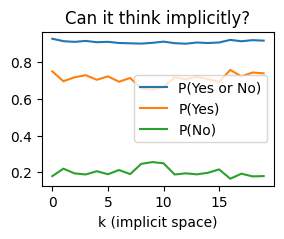

In [14]:
space_to_think_implicitly = "    "
logs = [get_stats(build_answer_prompt(question=question_on_avg_speed, thoughts=t + space_to_think_implicitly * k)) for k in range(20)]

ks = list(range(len(logs)))
plt.figure(figsize=(3, 2))
plt.plot(ks, [l["mass_yesno"]  for l in logs], label="P(Yes or No)")
plt.plot(ks, [l["p_yes_abs"] for l in logs], label="P(Yes)")
plt.plot(ks, [l["p_no_abs"]  for l in logs], label="P(No)")
plt.xlabel("k (implicit space)")
plt.title("Can it think implicitly?")
plt.legend()
plt.show()

In [15]:
def get_thoughts_trajectory(question, initial_th, max_new_tokens=60, n_chunks=6):
    cont = generate_thoughts(
        question,
        thoughts_so_far=initial_th,
        max_new_tokens=max_new_tokens,
    )
    
    ids = tokenizer(cont, add_special_tokens=False)["input_ids"]
    L = len(ids)

    chunks = [{
        "k": 0,
        "delta_th": "",
        "stats": get_stats(build_answer_prompt(question, "")),
    },
    {
        "k": 1,
        "delta_th": initial_th,
        "stats": get_stats(build_answer_prompt(question, initial_th)),
    }]

    prev_end = 0
    for k in range(1, n_chunks + 1):
        end = k * L // n_chunks
        delta_th = tokenizer.decode(ids[prev_end:end])
        new_th = tokenizer.decode(ids[:end]) 
        full_th = initial_th + " " + new_th
        prev_end = end
        stats = get_stats(build_answer_prompt(question, full_th))
        chunks.append({
            "k": k + 1,
            "delta_th": delta_th,
            "stats": stats,
        })

    return {
        "question": question,
        "continuation": cont,
        "chunks": chunks,
    }

To understand if it is model's opinion I decided to give it a chance to extend thoughts.

Initally I implemented step-by-step reasoning process, but it turned out to be extremely **noisy** due to constant jumps caused by the words **"But" and "But, wait"** that **interfered with convergence**.

In [16]:
# t = "Average of 60 and 40 is 50. 500/50 is 10."
trajectory = get_thoughts_trajectory(question=question_on_avg_speed, initial_th=t, max_new_tokens=512, n_chunks=20)

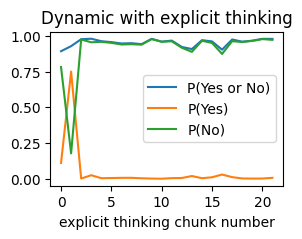

In [17]:
ks = list(range(len(trajectory["chunks"])))
plt.figure(figsize=(3, 2))
plt.plot(ks, [chunk["stats"]["mass_yesno"]  for chunk in trajectory["chunks"]], label="P(Yes or No)")
plt.plot(ks, [chunk["stats"]["p_yes_abs"] for chunk in trajectory["chunks"]], label="P(Yes)")
plt.plot(ks, [chunk["stats"]["p_no_abs"]  for chunk in trajectory["chunks"]], label="P(No)")
plt.xlabel("explicit thinking chunk number")
plt.title("Dynamic with explicit thinking")
plt.legend()
plt.show()

In [18]:
for i, chunk in enumerate(trajectory["chunks"][:4]):
    print(f"Thought #{i} in trajectory: {chunk['delta_th']}")

Thought #0 in trajectory: 
Thought #1 in trajectory: Average of 60 and 40 is 50. 500/50 is 10.
Thought #2 in trajectory: But wait, that's incorrect. Because the time taken for each journey is different. So, it's not a simple average
Thought #3 in trajectory: . Instead, I should calculate the time taken for each leg of the trip and then add them up.

Let me think again.


We observe that the model immediately flips its line of reasoning with a **"But"**, after which it rapidly converges to a confident "No". Periods where P(No) appears low do not reflect uncertainty about the conclusion; instead, they coincide with moments when P(Yes or No) is small. At these points the model is still generating intermediate thoughts and isn't ready for binary conclusion.

# Synthetic Dataset

The initial idea was to generate multiple instances of the average speed problem via prompt augmentations. The hypothesis was that two different “thought” variants in the prompt could activate competing internal representations in the model: for example, “average speed is the arithmetic mean of speeds” versus “average speed is the harmonic mean of speeds.”

PS. This assumption turned out to be **false**. The model does not appear to reliably separate these two ideas based on such prompt-level variations.

PPS. Moreover, I later realized that using different syntactic structures for the competing prompts is fundamentally **flawed**. Distinct syntax may allow the model to recognize and exploit superficial prompt templates rather than the underlying conceptual distinction, introducing spurious correlations and noise precisely at the stage where the goal is to isolate concept-specific internal representations.

In [19]:
NUM_WORDS = {
    10: "ten", 20: "twenty", 30: "thirty", 40: "forty",
    50: "fifty", 60: "sixty", 80: "eighty",
    100: "one hundred", 200: "two hundred",
    300: "three hundred", 400: "four hundred",
    500: "five hundred", 600: "six hundred"
}

STYLES = [
    "The road is {d} km long. A car goes from A to B at {v1} km/h and returns at {v2} km/h.",
    "A cyclist travels {d} km from A to B at {v1} km/h and rides back at {v2} km/h.",
    "A drone flies {d} km outward at {v1} km/h and returns at {v2} km/h.",
    "A courier covers {d} km from A to B at {v1} km/h and comes back at {v2} km/h.",
]

def maybe_word(x, p=0.4):
    return NUM_WORDS[x] if random.random() < p and x in NUM_WORDS else str(x)

In [20]:
def gen_example(ask_truth):
    dist = random.choice([300, 400, 500, 600])
    v1, v2 = random.sample([10, 15, 20, 30, 60, 80], 2)
    while max(v1, v2) / min(v1, v2) < 3:
      v1, v2 = random.sample([10, 15, 20, 30, 60, 80], 2)
    t_true = dist / v1 + dist / v2
    t_wrong = 2 * dist / ((v1 + v2) / 2)

    asked_time = round(t_true if ask_truth else t_wrong)
    
    v1_str, v2_str = maybe_word(v1), maybe_word(v2)
    right_thought = (
        f"The total time is {maybe_word(dist)}/{v1_str} "
        f"plus {maybe_word(dist)}/{v2_str}, "
        f"which is about {round(t_true)} hours."
    )

    wrong_thought = (
        f"The average speed is ({v1_str} + {v2_str}) / 2, "
        f"so for the full trip of {maybe_word(2*dist)} km, the total time is about {round(t_wrong)} hours."
    )

    style = random.choice(STYLES)
    question = (
        style.format(
            d=maybe_word(dist),
            v1=maybe_word(v1),
            v2=maybe_word(v2),
        )
        + f" Will the whole trip take about {maybe_word(asked_time)} hours?"
    )

    return {
        "question": question,
        "right_thought": right_thought,
        "wrong_thought": wrong_thought,
        "right_answer": "Yes" if ask_truth else "No",
        "meta": {
            "dist": dist,
            "v1": v1,
            "v2": v2,
            "ask_truth": ask_truth,
            "t_true": t_true,
            "t_wrong": t_wrong
        }
    }

In [21]:
def generate_dataset(n=200, ask_truth=False, seed=42):
    random.seed(seed)
    return [gen_example(ask_truth=ask_truth) for _ in range(n)]

Here is how it looks like

In [22]:
# In ask_truth=True question just asks t_true instead of t_wrong
generate_dataset(1, ask_truth=False) 

[{'question': 'The road is three hundred km long. A car goes from A to B at 15 km/h and returns at 80 km/h. Will the whole trip take about 13 hours?',
  'right_thought': 'The total time is 300/15 plus 300/eighty, which is about 24 hours.',
  'wrong_thought': 'The average speed is (15 + eighty) / 2, so for the full trip of 600 km, the total time is about 13 hours.',
  'right_answer': 'No',
  'meta': {'dist': 300,
   'v1': 15,
   'v2': 80,
   'ask_truth': False,
   't_true': 23.75,
   't_wrong': 12.631578947368421}}]

## Let's check that we can force "Yes"/"No" by injecting thoughts (as prompt)

In [23]:
# You can skip this section and simply download the data
# with open("/kaggle/working/ask_truth_dataset.json", "r") as f:
#     ask_truth_dataset = json.load(f)

# with open("/kaggle/working/ask_lie_dataset.json", "r") as f:
#     ask_lie_dataset = json.load(f)

# with open("/kaggle/working/ask_truth_predicts.json", "r") as f:
#     ask_truth_predicts = json.load(f)

# with open("/kaggle/working/ask_lie_predicts.json", "r") as f:
#     ask_lie_predicts = json.load(f)

In [24]:
def classify(stats, thr=0.75):
    py, pn = stats["p_yes_abs"], stats["p_no_abs"]
    if stats["mass_yesno"] < thr:
        return "Rejected"
    return "Yes" if py > pn else "No"

In [25]:
def analyze(predicts, right_answer, thr):
    assert right_answer in ("Yes", "No")

    n = len(predicts)
    r_cov = r_ok = 0
    w_cov = w_ok = 0
    wrong_answer = "No" if right_answer == "Yes" else "Yes"

    for i, (sr, sw) in enumerate(predicts):
        pr = classify(sr, thr)
        pw = classify(sw, thr)

        if pr == "Reject":
            print(i, "Rejected (right)")
        if pw == "Reject":
            print(i, "Rejected (wrong)")

        if pr != "Reject":
            r_cov += 1
            r_ok += (pr == right_answer)
            if pr != right_answer:
                print(i, "(couldn't force right answer)")

        if pw != "Reject":
            w_cov += 1
            w_ok += (pw == wrong_answer)
            if pw != wrong_answer:
                print(i, "(couldn't force wrong answer)")


    print("RIGHT thought: coverage", r_cov, "/", n, " accuracy", r_ok / max(r_cov, 1))
    print("WRONG thought: coverage", w_cov, "/", n, " accuracy", w_ok / max(w_cov, 1))

In [26]:
ask_truth_dataset = generate_dataset(200, ask_truth=True)
ask_truth_predicts = []
for el in ask_truth_dataset:
    ask_truth_predicts.append(
        (
            get_stats(build_answer_prompt(question=el["question"], thoughts=el["right_thought"])),
            get_stats(build_answer_prompt(question=el["question"], thoughts=el["wrong_thought"])),
        )
    )

In [27]:
analyze(ask_truth_predicts, right_answer="Yes", thr=0.75)

RIGHT thought: coverage 200 / 200  accuracy 1.0
WRONG thought: coverage 200 / 200  accuracy 1.0


In [28]:
ask_lie_dataset = generate_dataset(200, ask_truth=False)
ask_lie_predicts = []
for el in ask_lie_dataset:
    ask_lie_predicts.append(
        (
            get_stats(build_answer_prompt(question=el["question"], thoughts=el["right_thought"])),
            get_stats(build_answer_prompt(question=el["question"], thoughts=el["wrong_thought"])),
        )
    )

In [29]:
analyze(ask_lie_predicts, right_answer="No", thr=0.75)

11 (couldn't force wrong answer)
17 (couldn't force wrong answer)
18 (couldn't force wrong answer)
30 (couldn't force wrong answer)
49 (couldn't force wrong answer)
50 (couldn't force wrong answer)
57 (couldn't force wrong answer)
60 (couldn't force wrong answer)
61 (couldn't force wrong answer)
78 (couldn't force wrong answer)
82 (couldn't force wrong answer)
88 (couldn't force wrong answer)
112 (couldn't force wrong answer)
115 (couldn't force wrong answer)
122 (couldn't force wrong answer)
143 (couldn't force wrong answer)
144 (couldn't force wrong answer)
147 (couldn't force wrong answer)
155 (couldn't force wrong answer)
167 (couldn't force wrong answer)
175 (couldn't force wrong answer)
185 (couldn't force wrong answer)
186 (couldn't force wrong answer)
193 (couldn't force wrong answer)
197 (couldn't force wrong answer)
RIGHT thought: coverage 200 / 200  accuracy 1.0
WRONG thought: coverage 200 / 200  accuracy 0.875


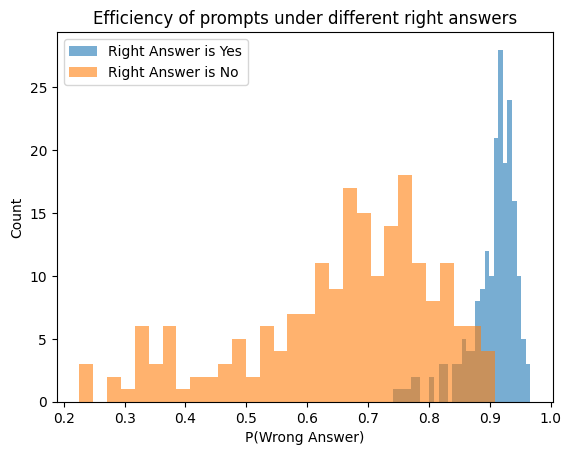

In [30]:
plt.figure()
plt.hist([ex_w["p_no_abs"] for (ex_r, ex_w) in ask_truth_predicts], bins=30, alpha=0.6, label="Right Answer is Yes")
plt.hist([ex_w["p_yes_abs"] for (ex_r, ex_w) in ask_lie_predicts], bins=30, alpha=0.6, label="Right Answer is No")
# mimicry data will be calculated later
# plt.hist([ex_w["p_no_abs"] for (ex_r, ex_w) in mimicry_ask_truth_predicts], bins=30, alpha=0.6, label="Right Answer is No [Mimicry]") 
plt.xlabel("P(Wrong Answer)")
plt.ylabel("Count")
plt.title("Efficiency of prompts under different right answers")
plt.legend()
plt.show()

**Look!** It appears harder to control the model when the correct answer is "No".

A natural intuition is that producing a "Yes" requires the model to accumulate compelling positive evidence, whereas "No" may be emitted under even slight doubt or uncertainty. Under this view, pushing the model toward "Yes" would correspond to increasing confidence, while pushing it toward "No" would merely amplify doubt.

However, intervention to neurons (**not prompts**) still allows both increasing and decreasing commitment in either direction, independently of whether the correct answer is "Yes" or "No". This indicates that the identified direction does not merely modulate uncertainty or doubt, but instead directly controls the model’s commitment to a binary decision, i.e., belief polarity rather than evidential strength.

For clarity, later analysis focuses on of cases where the correct answer is "Yes", but this choice is made for simplicity, not because the effect is **asymmetric**.

In [31]:
with open("/kaggle/working/ask_truth_dataset.json", "w") as f:
    json.dump(ask_truth_dataset, f)
with open("/kaggle/working/ask_lie_dataset.json", "w") as f:
    json.dump(ask_lie_dataset, f)    
with open("/kaggle/working/ask_truth_predicts.json", "w") as f:
    json.dump(ask_truth_predicts, f)
with open("/kaggle/working/ask_lie_predicts.json", "w") as f:
    json.dump(ask_lie_predicts, f)    

Let's inspect one case in which model resist to change its preference.

In [32]:
# With no reasoning
problem_id = 167
el = ask_lie_dataset[problem_id]
print("Question:", el["question"])
for t in ["", el["wrong_thought"], el["right_thought"]]:
    s = get_stats(build_answer_prompt(question=el["question"], thoughts=t))
    print(f"Thoughts: *{t}* -->> Probs: P(Yes)={s['p_yes_cond']:.2f} P(No)={s['p_no_cond']:.2f}")

Question: A courier covers 300 km from A to B at 60 km/h and comes back at ten km/h. Will the whole trip take about 17 hours?
Thoughts: ** -->> Probs: P(Yes)=0.13 P(No)=0.87
Thoughts: *The average speed is (sixty + 10) / 2, so for the full trip of 600 km, the total time is about 17 hours.* -->> Probs: P(Yes)=0.37 P(No)=0.63
Thoughts: *The total time is 300/sixty plus 300/10, which is about 35 hours.* -->> Probs: P(Yes)=0.00 P(No)=1.00


We see that model actually increased probability of wrong prediction. But the correct answer still dominated. I think it's related to the asymmetry of the problem - on average, a "Yes" answer requires more evidence, since "No" **leaves room** for reasoning along the lines of "No" + "Wait, let's recalculate..."

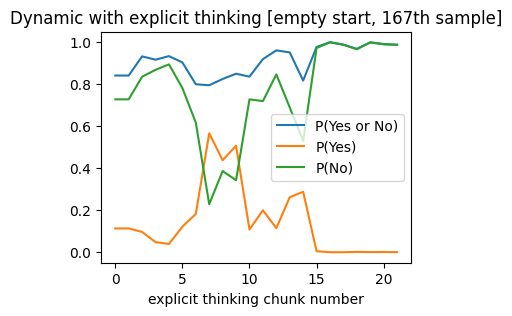

Thought #0 in trajectory: 
Thought #1 in trajectory: 
Thought #2 in trajectory: Okay, so I need to figure out if the total time for the courier's trip from A to B and back to A


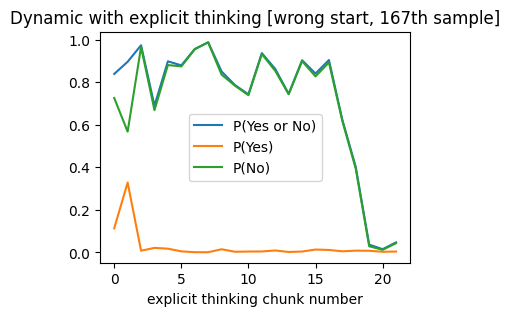

Thought #0 in trajectory: 
Thought #1 in trajectory: The average speed is (sixty + 10) / 2, so for the full trip of 600 km, the total time is about 17 hours.
Thought #2 in trajectory: But wait, the average speed is not simply the arithmetic mean. Let me think again. The correct approach is to calculate the


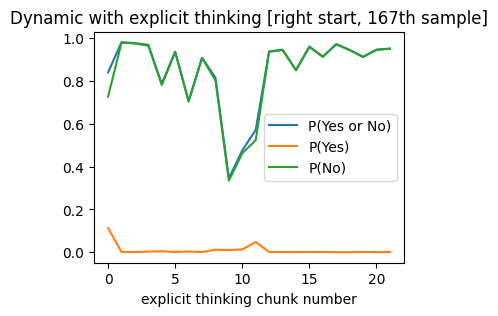

Thought #0 in trajectory: 
Thought #1 in trajectory: The total time is 300/sixty plus 300/10, which is about 35 hours.
Thought #2 in trajectory: Wait, so the courier covers 300 km from A to B at 60 km/h, which takes 


In [33]:
for tag, t in [("empty", ""), ("wrong", el["wrong_thought"]), ("right", el["right_thought"])]:
    trajectory = get_thoughts_trajectory(question=el["question"], initial_th=t, max_new_tokens=512, n_chunks=20)
    ks = list(range(len(trajectory["chunks"])))
    plt.figure(figsize=(4, 3))
    plt.plot(ks, [chunk["stats"]["mass_yesno"]  for chunk in trajectory["chunks"]], label="P(Yes or No)")
    plt.plot(ks, [chunk["stats"]["p_yes_abs"] for chunk in trajectory["chunks"]], label="P(Yes)")
    plt.plot(ks, [chunk["stats"]["p_no_abs"]  for chunk in trajectory["chunks"]], label="P(No)")
    plt.xlabel("explicit thinking chunk number")
    plt.title(f"Dynamic with explicit thinking [{tag} start, {problem_id}th sample]")
    plt.legend()
    plt.show()
    for i, chunk in enumerate(trajectory["chunks"][:3]):
        print(f"Thought #{i} in trajectory: {chunk['delta_th']}")

Presumably the model believes that the answer is "No". And convergence to its "real answer" is **more stable** when the initial hint is correct. But anyway it **may diverge**, as we see :(

## Lets approximate results of reasoning

In [34]:
def get_reasoning_effect(ex, initial_th, max_new_tokens):
    q = ex["question"]
    right = ex["right_answer"]
    assert right in ["Yes", "No"]
    s0 = get_stats(build_answer_prompt(q, initial_th))
    p0 = s0["p_yes_abs"] if right == "No" else s0["p_no_abs"] # p wrong before
    cont = generate_thoughts(
        q,
        thoughts_so_far=initial_th,
        max_new_tokens=max_new_tokens,
    )
    s1 = get_stats(build_answer_prompt(q, initial_th + " " + cont))
    p1 = s1["p_yes_abs"] if right == "No" else s1["p_no_abs"] # p wrong after
    return p0, p1

In [35]:
def quick_check(dataset, max_new_tokens, k=5, seed=0):
    random.seed(seed)
    idxs = random.sample(range(len(dataset)), k)
    for i in idxs:
        ex = dataset[i]
        print(f"Sample #{i}")
        for name, th in [("wrong", ex["wrong_thought"]), ("right", ex["right_thought"]), ("empty", "")]:
            p0, p1 = get_reasoning_effect(ex=ex, initial_th=th, max_new_tokens=max_new_tokens)
            print(name, "p_wrong:", round(p0, 3), "-->>", round(p1, 3))

In [36]:
def reasoning_outcome(p0, p1, eps=1e-3):
    if p1 < p0 - eps:
        return "improved"
    elif p1 > p0 + eps:
        return "worsened"
    else:
        return "neutral"

In [37]:
def collect_reasoning_stats(dataset, max_new_tokens, seed=0):
    random.seed(seed)
    idxs = list(range(len(dataset)))#random.sample(range(len(dataset)), k)
    results = {"wrong": Counter(), "right": Counter(), "empty": Counter(),}
    deltas = {"wrong": [], "right": [], "empty": [],}
    for i in idxs:
        ex = dataset[i]
        for name, th in [("wrong", ex["wrong_thought"]), ("right", ex["right_thought"]), ("empty", "")]:
            p0, p1 = get_reasoning_effect(ex, th, max_new_tokens)
            results[name][reasoning_outcome(p0, p1)] += 1
            deltas[name].append(p1 - p0)
    return results, deltas

In [38]:
# It is supposed to check how efficient reasoning is in fixing biases from different kinds of prompts
# but this call is incredibly expensive - it works ~1h in my case
# results, deltas = collect_reasoning_stats(ask_truth_dataset, max_new_tokens=128)
# for name in results:
#     print(name, dict(results[name]))
# quick_check(ask_truth_dataset, max_new_tokens=128, k=32)

Soo... everyhing is messy. Sometimes reasoning fixes problem, sometimes it **creates** them. Moreover, we can't be sure that after 128, 256, or even 512 tokens of reasoning model converge to its "real belief" which is additional noise. 

But we definitely see that **dynamics depends on the initial thought** and that **often it moves to the right direction (if starts with wrong thought)**. It gives us a hope that LLM actually understand what is right answer. And the fact that we can force it to give us wrong answer under wrong thoght is illustrative - it may mean that model has silent disagreement that a) leads reasoning to the right direction but b) isn't strong enough to explicitly answer contrary to the proposed wrong thought. 

That is why I had a hope to **capture (at least) this disagreement and manipulate it**.

# Finding "disagreement" neurons

## Collecting activations
For simplicitly I decided to condier `ask_truth` dataset (to not have a deal with doubting model)

In [39]:
# To save your time
# ask_truth_acts = torch.load("/kaggle/working/ask_truth_acts.pt", map_location="cpu")
# ask_truth_acts_right = ask_truth_acts["ask_truth_acts_right"]
# ask_truth_acts_wrong = ask_truth_acts["ask_truth_acts_wrong"]

In [40]:
def make_hook(store, layer_idx):
    def hook(module, inp, out):
        store[layer_idx].append(out[:, -1, :].detach().cpu())
    return hook

In [41]:
ask_truth_acts_right = {i: [] for i in range(len(model.model.layers))}
handles = []
for i, layer in enumerate(model.model.layers):
    handles.append(layer.register_forward_hook(make_hook(ask_truth_acts_right, i)))
for ex in ask_truth_dataset:
    prompt = build_answer_prompt(ex["question"], ex["right_thought"])
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        model(**inputs, use_cache=False)
for h in handles:
    h.remove()

In [42]:
ask_truth_acts_wrong = {i: [] for i in range(len(model.model.layers))}
handles = []
for i, layer in enumerate(model.model.layers):
    handles.append(layer.register_forward_hook(make_hook(ask_truth_acts_wrong, i)))
for ex in ask_truth_dataset:
    prompt = build_answer_prompt(ex["question"], ex["wrong_thought"])
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        model(**inputs, use_cache=False)
for h in handles:
    h.remove()

In [43]:
torch.save(
    {
        "ask_truth_acts_right": ask_truth_acts_right,
        "ask_truth_acts_wrong": ask_truth_acts_wrong,
    },
    "/kaggle/working/ask_truth_acts.pt"
)

## Linear probing

Let's see how descriptive are activations of the last token

In [44]:
def pca_project(X, k):
    return PCA(n_components=k, random_state=0).fit_transform(X)

In [45]:
def build_xy(acts_right, acts_wrong, layer):
    Xr = torch.cat(acts_right[layer], dim=0)
    Xw = torch.cat(acts_wrong[layer], dim=0)
    X = torch.cat([Xr, Xw], dim=0).numpy()
    y = np.concatenate([
        np.ones(len(Xr)),
        np.zeros(len(Xw))
    ])
    return X, y

In [46]:
def probe_layer(acts_right, acts_wrong, layer, k=5, seed=0, test_size=0.3):
    X, y = build_xy(acts_right, acts_wrong, layer)
    X = pca_project(X, k)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
    clf = LogisticRegression(max_iter=100, C=0.001, penalty="l2", solver="lbfgs", n_jobs=1)
    clf.fit(Xtr, ytr)
    return accuracy_score(yte, clf.predict(Xte))

In [47]:
layer_acc = []
for layer in range(1, 28, 2):
    acc = probe_layer(ask_truth_acts_right, ask_truth_acts_wrong, layer, k=1, test_size=0.99)
    layer_acc.append(acc)
    print(f"Layer {layer:02d}: acc = {acc:.3f}")

Layer 01: acc = 1.000
Layer 03: acc = 1.000
Layer 05: acc = 1.000
Layer 07: acc = 1.000
Layer 09: acc = 1.000
Layer 11: acc = 1.000
Layer 13: acc = 1.000
Layer 15: acc = 1.000
Layer 17: acc = 1.000
Layer 19: acc = 1.000
Layer 21: acc = 1.000
Layer 23: acc = 1.000
Layer 25: acc = 1.000
Layer 27: acc = 1.000


**It was the key moment of this project.**

With only four training points, even after projection onto a one-dimensional subspace, it was already possible to perfectly separate LLM outputs produced with wrong versus right prompts. This raised immediate **suspicion**: such clean separability with so little data is unlikely to reflect a genuine conceptual distinction. A more plausible explanation is that the **separation is driven by prompt syntax** rather than by the underlying reasoning content.

At this point, I considered the projection approach to be fundamentally compromised, especially given the limited time available to redesign the problem. However, a simple alternative idea emerged. Instead of contrasting correct reasoning with genuinely incorrect reasoning, I constructed wrong-style (**mimicry**) thoughts that follow the typical template of an incorrect solution but include an **intentional arithmetic mistake**. The reasoning is flawed in form, yet the conclusion is correct! This construction preserves the stylistic and structural features of wrong thoughts while aligning the final answer with the correct outcome. As a result, it allows us to **disentangle template- or style- related signals** from other factors.

## Mimicry dataset. Are our signals caused solely by template?

In [48]:
def gen_mimicry_example(ask_truth):
    dist = random.choice([300, 400, 500, 600])
    v1, v2 = random.sample([10, 15, 20, 30, 60, 80], 2)
    while max(v1, v2) / min(v1, v2) < 3:
      v1, v2 = random.sample([10, 15, 20, 30, 60, 80], 2)
    t_true = dist / v1 + dist / v2
    t_wrong = 2 * dist / ((v1 + v2) / 2)

    asked_time = round(t_true if ask_truth else t_wrong)
    
    v1_str, v2_str = maybe_word(v1), maybe_word(v2)
    right_thought = (
        f"The total time is {maybe_word(dist)}/{v1_str} "
        f"plus {maybe_word(dist)}/{v2_str}, "
        f"which is about {round(t_true)} hours."
    )

    wrong_thought = (
        f"The average speed is ({v1_str} + {v2_str}) / 2, "
        f"so for the full trip of {maybe_word(2*dist)} km, the total time is about {round(t_true)} hours." # MIMIC: t_true!
    )

    style = random.choice(STYLES)
    question = (
        style.format(
            d=maybe_word(dist),
            v1=maybe_word(v1),
            v2=maybe_word(v2),
        )
        + f" Will the whole trip take about {maybe_word(asked_time)} hours?"
    )

    return {
        "question": question,
        "right_thought": right_thought,
        "wrong_thought": wrong_thought,
        "right_answer": "Yes" if ask_truth else "No",
        "meta": {
            "dist": dist,
            "v1": v1,
            "v2": v2,
            "ask_truth": ask_truth,
            "t_true": t_true,
            "t_wrong": t_wrong
        }
    }

In [49]:
def generate_mimicry_dataset(n=200, ask_truth=False, seed=42):
    random.seed(seed)
    return [gen_mimicry_example(ask_truth=ask_truth) for _ in range(n)]

In [50]:
mimicry_ask_truth_dataset = generate_mimicry_dataset(200, ask_truth=True)
mimicry_ask_truth_predicts = []
for el in mimicry_ask_truth_dataset:
    mimicry_ask_truth_predicts.append(
        (
            get_stats(build_answer_prompt(question=el["question"], thoughts=el["right_thought"])),
            get_stats(build_answer_prompt(question=el["question"], thoughts=el["wrong_thought"])),
        )
    )

In [51]:
analyze(mimicry_ask_truth_predicts, right_answer="Yes", thr=0.75)

0 (couldn't force wrong answer)
1 (couldn't force wrong answer)
2 (couldn't force wrong answer)
3 (couldn't force wrong answer)
4 (couldn't force wrong answer)
5 (couldn't force wrong answer)
6 (couldn't force wrong answer)
7 (couldn't force wrong answer)
8 (couldn't force wrong answer)
9 (couldn't force wrong answer)
10 (couldn't force wrong answer)
11 (couldn't force wrong answer)
12 (couldn't force wrong answer)
13 (couldn't force wrong answer)
14 (couldn't force wrong answer)
15 (couldn't force wrong answer)
16 (couldn't force wrong answer)
17 (couldn't force wrong answer)
18 (couldn't force wrong answer)
19 (couldn't force wrong answer)
20 (couldn't force wrong answer)
21 (couldn't force wrong answer)
22 (couldn't force wrong answer)
23 (couldn't force wrong answer)
24 (couldn't force wrong answer)
25 (couldn't force wrong answer)
26 (couldn't force wrong answer)
27 (couldn't force wrong answer)
28 (couldn't force wrong answer)
29 (couldn't force wrong answer)
30 (couldn't force w

**INCREDIBLE RESULT!** When a wrong reasoning approach is presented in a wrong-style thought, but the flawed computation nevertheless produces the same numerical result stated in the question, the model does not hesitate and does not revise its belief. Instead, it continues to endorse the statement as true.

In other words, **the presence of an incorrect reasoning path is insufficient** to trigger doubt or belief reversal as long as the final numerical outcome aligns with the queried claim. This strongly suggests that the model’s commitment is driven more by alignment with the asserted conclusion than by internal consistency or validity of the reasoning process itself (**at least under pressure to give binary answer right now**).

Btw, this meant that my initial idea to activate certain approaches to problems ("ideas") **failed**. 

In [52]:
# The ONLY diff is correct number in wrong_thought
mimicry_ask_truth_dataset[42], ask_truth_dataset[42],

({'question': 'A cyclist travels five hundred km from A to B at 20 km/h and rides back at eighty km/h. Will the whole trip take about 31 hours?',
  'right_thought': 'The total time is five hundred/twenty plus five hundred/eighty, which is about 31 hours.',
  'wrong_thought': 'The average speed is (twenty + eighty) / 2, so for the full trip of 1000 km, the total time is about 31 hours.',
  'right_answer': 'Yes',
  'meta': {'dist': 500,
   'v1': 20,
   'v2': 80,
   'ask_truth': True,
   't_true': 31.25,
   't_wrong': 20.0}},
 {'question': 'A cyclist travels five hundred km from A to B at 20 km/h and rides back at eighty km/h. Will the whole trip take about 31 hours?',
  'right_thought': 'The total time is five hundred/twenty plus five hundred/eighty, which is about 31 hours.',
  'wrong_thought': 'The average speed is (twenty + eighty) / 2, so for the full trip of 1000 km, the total time is about 20 hours.',
  'right_answer': 'Yes',
  'meta': {'dist': 500,
   'v1': 20,
   'v2': 80,
   'as

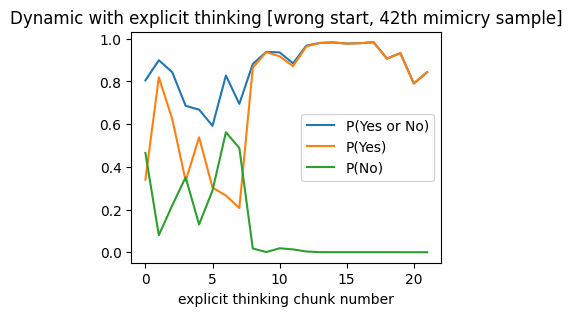

In [53]:
el = mimicry_ask_truth_dataset[42] 
trajectory = get_thoughts_trajectory(question=el["question"], initial_th=el["wrong_thought"], max_new_tokens=512, n_chunks=20)
ks = list(range(len(trajectory["chunks"])))
plt.figure(figsize=(4, 3))
plt.plot(ks, [chunk["stats"]["mass_yesno"]  for chunk in trajectory["chunks"]], label="P(Yes or No)")
plt.plot(ks, [chunk["stats"]["p_yes_abs"] for chunk in trajectory["chunks"]], label="P(Yes)")
plt.plot(ks, [chunk["stats"]["p_no_abs"]  for chunk in trajectory["chunks"]], label="P(No)")
plt.xlabel("explicit thinking chunk number")
plt.title(f"Dynamic with explicit thinking [wrong start, 42th mimicry sample]")
plt.legend()
plt.show()

In [54]:
for i, chunk in enumerate(trajectory["chunks"][:10]):
    print(f"Thought #{i} in trajectory: {chunk['delta_th']}")

Thought #0 in trajectory: 
Thought #1 in trajectory: The average speed is (twenty + eighty) / 2, so for the full trip of 1000 km, the total time is about 31 hours.
Thought #2 in trajectory: To calculate the average speed for the entire trip, I need to consider the total distance traveled and the total time taken. So
Thought #3 in trajectory: , the total distance is 1000 km. The time taken for each leg of the trip can be calculated by dividing
Thought #4 in trajectory:  the distance by the speed for that leg.

First leg (A to B): 500 km at 20
Thought #5 in trajectory:  km/h. Time = 500 / 20 = 25 hours.

Second leg (B to A):
Thought #6 in trajectory:  500 km at 80 km/h. Time = 500 / 80 = 6.
Thought #7 in trajectory: 25 hours.

Total time = 25 + 6.25 = 31.25 hours.


Thought #8 in trajectory: So, the total time is 31.25 hours, which is approximately 31 hours. Therefore, the initial
Thought #9 in trajectory:  statement is correct.
</think>

To determine if the entire trip takes approximate

We see, that result matching to the number in question kinda gave **inertia to the reasoning** (at least in some calls; note - reasoning is still a bit stochastic idk why), but then model recognizes wrong approach, flips "beliefs" and does correct calculations. Anyway it converges to the right answer.

## Collecting activation of mimicry dataset

In [55]:
mimicry_ask_truth_acts_wrong = {i: [] for i in range(len(model.model.layers))}
handles = []
for i, layer in enumerate(model.model.layers):
    handles.append(layer.register_forward_hook(make_hook(mimicry_ask_truth_acts_wrong, i)))
for ex in mimicry_ask_truth_dataset:
    prompt = build_answer_prompt(ex["question"], ex["wrong_thought"])
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        model(**inputs, use_cache=False)
for h in handles:
    h.remove()


torch.save(mimicry_ask_truth_acts_wrong,"/kaggle/working/mimicry_ask_truth_acts_wrong.pt")

In [56]:
# Okay. Something changed
layer_acc = []
for layer in range(1, 28, 2):
    acc = probe_layer(ask_truth_acts_wrong, mimicry_ask_truth_acts_wrong, layer, k=1, test_size=0.99)
    layer_acc.append(acc)
    print(f"Layer {layer:02d}: acc = {acc:.3f}")

Layer 01: acc = 0.495
Layer 03: acc = 0.500
Layer 05: acc = 0.497
Layer 07: acc = 0.515
Layer 09: acc = 0.533
Layer 11: acc = 0.556
Layer 13: acc = 0.508
Layer 15: acc = 0.510
Layer 17: acc = 1.000
Layer 19: acc = 1.000
Layer 21: acc = 1.000
Layer 23: acc = 1.000
Layer 25: acc = 1.000
Layer 27: acc = 1.000


In [57]:
layer_acc = []
for layer in range(1, 28, 2):
    acc = probe_layer(ask_truth_acts_wrong, mimicry_ask_truth_acts_wrong, layer, k=50, test_size=0.3)
    layer_acc.append(acc)
    print(f"Layer {layer:02d}: acc = {acc:.3f}")

Layer 01: acc = 0.575
Layer 03: acc = 0.608
Layer 05: acc = 0.875
Layer 07: acc = 0.967
Layer 09: acc = 1.000
Layer 11: acc = 1.000
Layer 13: acc = 1.000
Layer 15: acc = 1.000
Layer 17: acc = 1.000
Layer 19: acc = 1.000
Layer 21: acc = 1.000
Layer 23: acc = 1.000
Layer 25: acc = 1.000
Layer 27: acc = 1.000


The situation doesn't look ideal, but it's definitely improving. In any case, at that point, I had no other direction to continue.

# Steering

Why 18? 
It was found **empirically** during early per-query stimulation experiments. At that stage, no specific layer was expected to work. A single query was selected, a direction D was computed between mimicry-wrong and wrong thoughts, and the effect of shifting activations along this direction was tested across layers.

A meaningful and consistent response was first observed when intervening at layer 18. This same layer was then tested on a different query, where the effect reproduced. Following this, the direction D was recomputed using all available queries. The resulting behavior remained stable, leading to the setup used throughout the rest of the notebook.

In [58]:
# Minimal toolkit for steering
# Our mimicry contrasts use prompts only with different thoughts
ask_truth_acts = torch.load("/kaggle/working/ask_truth_acts.pt", map_location="cpu")
ask_truth_acts_wrong = ask_truth_acts["ask_truth_acts_wrong"]
mimicry_ask_truth_acts_wrong = torch.load("/kaggle/working/mimicry_ask_truth_acts_wrong.pt", map_location="cpu")
assert len(ask_truth_acts_wrong) == len(mimicry_ask_truth_acts_wrong)
assert len(ask_truth_acts_wrong[0]) == len(mimicry_ask_truth_acts_wrong[0])

# D = torch.load("/kaggle/working/D.pt")

In [59]:
LAYER = 18
D = torch.stack([mimicry_ask_truth_acts_wrong[LAYER][i] - ask_truth_acts_wrong[LAYER][i] for i in range(len(ask_truth_acts_wrong[LAYER]))]).mean(dim=0)

In [60]:
def make_delta_hook(delta, alpha):
    def hook(module, inp, out):
        if alpha == 0:
            return out
        if isinstance(out, tuple):
            h = out[0]
            h = h + alpha * delta.to(device=h.device, dtype=h.dtype)
            return (h,) + out[1:]
        else:
            return out + alpha * delta.to(device=out.device, dtype=out.dtype)
    return hook

# Old version. Probably, in some cases it leads to different comp. graph
# which changes output distribution
# def make_delta_hook(layer_id, delta, alpha):
#     def hook(module, inp, out):
#         out = out + alpha * delta.to(out.device)
#         return out
#     return hook

In [61]:
def see_reaction(q, th, alpha):
    prompt = build_answer_prompt(q, th)
    s_base = get_stats(prompt)
    print("baseline:", s_base)
    handle = model.model.layers[LAYER].register_forward_hook(make_delta_hook(D, alpha))
    s_plus = get_stats(prompt)
    handle.remove()
    print("with +Δ:", s_plus)
    handle = model.model.layers[LAYER].register_forward_hook(make_delta_hook(D, -alpha))
    s_minus = get_stats(prompt)
    handle.remove()
    print("with -Δ:", s_minus)    

Then I immediately decided to try it on **mimicry data**. And it worked:

In [62]:
# Probably, this was the first first time I met some meaningful reaction
# At that time D was calculated for specific queries, i.e. 17 in this case
# see_reaction(ask_truth_dataset[17]["question"], ask_truth_dataset[17]["wrong_thought"], alpha=1.0)

In [63]:
see_reaction(ask_truth_dataset[42]["question"], ask_truth_dataset[42]["wrong_thought"], alpha=1.0)

baseline: {'margin': -4.78125, 'odds': 0.008385510525424083, 'p_yes_cond': 0.00831214430245161, 'p_no_cond': 0.9916878556975484, 'p_yes_abs': 0.007694244384765625, 'p_no_abs': 0.91796875, 'mass_yesno': 0.9256629943847656}
with +Δ: {'margin': 2.15625, 'odds': 8.638681785041102, 'p_yes_cond': 0.8962857722752182, 'p_no_cond': 0.10371422772478181, 'p_yes_abs': 0.80859375, 'p_no_abs': 0.09356689453125, 'mass_yesno': 0.90216064453125}
with -Δ: {'margin': -6.9921875, 'odds': 0.0009190339444511671, 'p_yes_cond': 0.0009178411283242828, 'p_no_cond': 0.9990821588716757, 'p_yes_abs': 0.0008325576782226562, 'p_no_abs': 0.90625, 'mass_yesno': 0.9070825576782227}


## Plotting reactions for all questions

In [64]:
def belief_vs_alpha(question, thought, alphas, layer, D):
    prompt = build_answer_prompt(question, thought)
    results = []
    for alpha in alphas:
        if alpha == 0:
            stats = get_stats(prompt)
        else:
            h = model.model.layers[layer].register_forward_hook(
                make_delta_hook(D, alpha)
            )
            stats = get_stats(prompt)
            h.remove()

        results.append({
            "alpha": alpha,
            "p_yes": stats["p_yes_abs"],
            "p_no": stats["p_no_abs"],
            "mass": stats["mass_yesno"],
            "margin": stats["margin"],
        })
    return results

In [65]:
def collect_curves(questions, thoughts, alphas, layer, D, tag):
    curves = []
    for i, (q, th) in enumerate(zip(questions, thoughts)):
        pts = belief_vs_alpha(q, th, alphas, layer, D)
        for p in pts:
            curves.append({
                "i": i,
                "tag": tag,
                **p
            })
    return curves

In [66]:
alphas = [-3, -1.5, -1, -0.7, -0.5, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 3]
idxs = list(range(len(ask_truth_dataset)))
for ex1, ex2 in zip(ask_truth_dataset, mimicry_ask_truth_dataset):
    assert ex1["question"] == ex2["question"]
qs  = [ask_truth_dataset[i]["question"] for i in idxs]
ths_wrong = [ask_truth_dataset[i]["wrong_thought"] for i in idxs]
mimicry_ths_wrong = [mimicry_ask_truth_dataset[i]["wrong_thought"] for i in idxs]

curves_wrong = collect_curves(qs, ths_wrong, alphas, LAYER, D, tag="wrong")
curves_mimicry_wrong = collect_curves(qs, mimicry_ths_wrong, alphas, LAYER, D, tag="fake")

In [67]:
df_wrong = pd.DataFrame(curves_wrong)
df_mimicry_wrong  = pd.DataFrame(curves_mimicry_wrong)

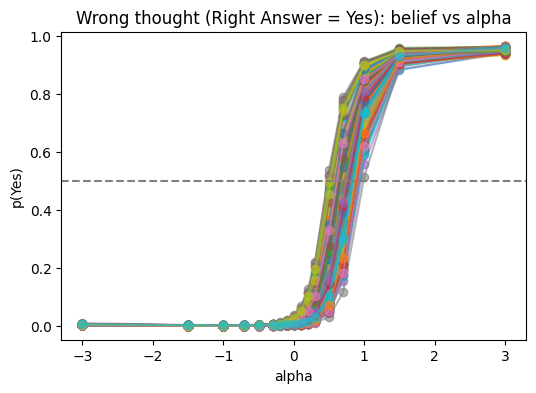

In [68]:
plt.figure(figsize=(6, 4))
for i, g in df_wrong.groupby("i"):
    g = g.sort_values("alpha")
    plt.plot(g["alpha"], g["p_yes"], marker="o", alpha=0.6)
plt.axhline(0.5, color="gray", linestyle="--")
plt.xlabel("alpha")
plt.ylabel("p(Yes)")
plt.title("Wrong thought (Right Answer = Yes): belief vs alpha")
plt.show()

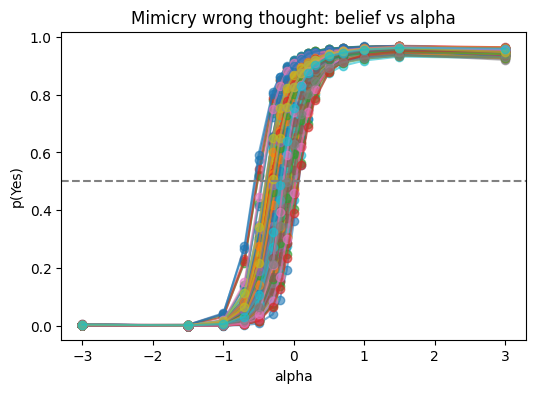

In [69]:
plt.figure(figsize=(6, 4))
for i, g in df_mimicry_wrong.groupby("i"):
    g = g.sort_values("alpha")
    plt.plot(g["alpha"], g["p_yes"], marker="o", alpha=0.6)
plt.axhline(0.5, color="gray", linestyle="--")
plt.xlabel("alpha")
plt.ylabel("p(Yes)")
plt.title("Mimicry wrong thought: belief vs alpha")
plt.show()

## Does it work on samples where right answer is "No"?

In [70]:
qs  = [ex["question"] for ex in ask_lie_dataset]
ths_lie_wrong = [ex["wrong_thought"] for ex in ask_lie_dataset]
curves_lie_wrong = collect_curves(qs, ths_lie_wrong, alphas, LAYER, D, tag="wrong")

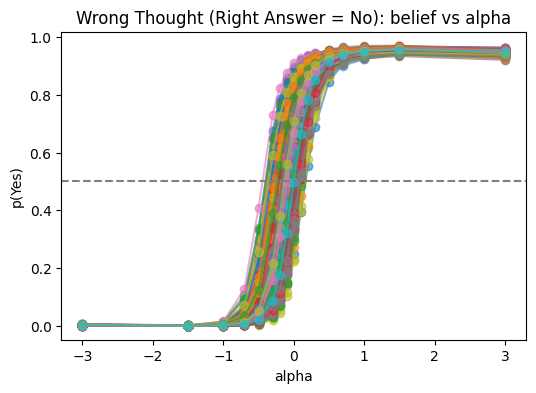

In [71]:
df_lie_wrong  = pd.DataFrame(curves_lie_wrong)
plt.figure(figsize=(6, 4))
for i, g in df_lie_wrong.groupby("i"):
    g = g.sort_values("alpha")
    plt.plot(g["alpha"], g["p_yes"], marker="o", alpha=0.6)
plt.axhline(0.5, color="gray", linestyle="--")
plt.xlabel("alpha")
plt.ylabel("p(Yes)")
plt.title("Wrong Thought (Right Answer = No): belief vs alpha")
plt.show()

# Is D specific to our synthetic data?

## OOD: Does it work at least on new arithmetical problem?
Note, we mix questions with right answer Yes and No

In [72]:
def gen_addition_example(correct=True):
    a = random.randint(2, 300)
    b = random.randint(2, 300)
    true = a + b
    if correct:
        claimed = true
    else:
        claimed = int(true * random.choice([2/3, 3/2]))
    q = f"{a} + {b} = {claimed}?"
    right_answer = "Yes" if correct else "No"
    wrong_thought = f"{a} plus {b} is around {claimed}, so the claim seems correct."
    return {
        "question": q,
        "wrong_thought": wrong_thought,
        "right_answer": right_answer,
    }

In [73]:
ood_arithmetic_dataset = [gen_addition_example(i % 2 == 0) for i in range(100)]

In [74]:
questions = [ex["question"] for ex in ood_arithmetic_dataset]
thoughts   = [ex["wrong_thought"] for ex in ood_arithmetic_dataset]

In [75]:
# Note, this dataset is mixed (right answers are both Yes and No)
# That is why wrong thoughts are actually wrong only at odd positions
i = 0
(
    ood_arithmetic_dataset[i]["question"], 
    ood_arithmetic_dataset[i]["wrong_thought"], 
    get_stats(build_answer_prompt(ood_arithmetic_dataset[i]["question"], ood_arithmetic_dataset[i]["wrong_thought"]))
)

('114 + 296 = 410?',
 '114 plus 296 is around 410, so the claim seems correct.',
 {'margin': 4.625,
  'odds': 102.00277308269969,
  'p_yes_cond': 0.9902952846875847,
  'p_no_cond': 0.009704715312415343,
  'p_yes_abs': 0.9482421875,
  'p_no_abs': 0.0092926025390625,
  'mass_yesno': 0.9575347900390625})

In [76]:
i = 1
(
    ood_arithmetic_dataset[i]["question"], 
    ood_arithmetic_dataset[i]["wrong_thought"], 
    get_stats(build_answer_prompt(ood_arithmetic_dataset[i]["question"], ood_arithmetic_dataset[i]["wrong_thought"]))
)

('200 + 183 = 255?',
 '200 plus 183 is around 255, so the claim seems correct.',
 {'margin': 5.546875,
  'odds': 256.43494327896633,
  'p_yes_cond': 0.9961168635380439,
  'p_no_cond': 0.003883136461956187,
  'p_yes_abs': 0.95654296875,
  'p_no_abs': 0.0037288665771484375,
  'mass_yesno': 0.9602718353271484})

In [77]:
curves_ood_wrong = collect_curves(
    questions=questions,
    thoughts=thoughts,
    alphas=[-10, -5, -3, -2, -1, -0.7, -0.5, -0.25,  -0.1, 0, 0.1, 0.25, 0.5, 0.7, 1, 2, 3, 5, 10],
    layer=LAYER,
    D=D,
    tag="ood"
)

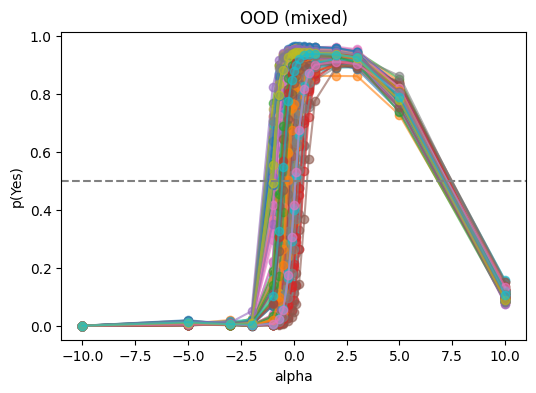

In [78]:
df_ood  = pd.DataFrame(curves_ood_wrong)
plt.figure(figsize=(6, 4))
for i, g in df_ood.groupby("i"):
    g = g.sort_values("alpha")
    plt.plot(g["alpha"], g["p_yes"], marker="o", alpha=0.6)
plt.axhline(0.5, color="gray", linestyle="--")
plt.xlabel("alpha")
plt.ylabel("p(Yes)")
plt.title("OOD (mixed)")
plt.show()

## With different kind of prompts?

In [79]:
question = "Is it true that if you start with 7 apples, give away 3, and then receive 2, you end up with more apples than you started with?"

thoughts = [
    ("wrong_arithmetic", "7 minus 3 is 5, and adding 2 gives 7, so you end with the same amount."),
    ("direct_oral_arithmetic", "Starting with 7, giving away 3 leaves 4, then receiving 2 gives 6, which is less than 7."),
    ("implicit_oral_arithmetic", "You lose more than you gain overall, so you do not end up with more than you started with."),
    ("explicit_arith",  "7 - 3 = 4. 4 + 2 = 6. 6 < 7."),
    ("explicit_arith_with_conclusion", "7 - 3 = 4. 4 + 2 = 6. 6 < 7. So I end up with less apples."),
    ("authority",       "This is basic everyday counting that children learn early on.."),
    ("approximate",     "We give away more apples than we get back, so the final amount should be smaller."),
    ("positive_belief",     "The statement appears straightforward and trustworthy."),
    ("negative_belief",     "The statement seems to be false."),
    ("empty",           ""),
]

rows = []

for label, thought in thoughts:
    prompt = build_answer_prompt(question, thought)

    for alpha in [-10, -5, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 5, 10]:
        if alpha == 0:
            stats = get_stats(prompt)
        else:
            h = model.model.layers[LAYER].register_forward_hook(make_delta_hook(D, alpha))
            stats = get_stats(prompt)
            h.remove()

        rows.append({
            "thought": label,
            "alpha": alpha,
            "p_yes": stats["p_yes_abs"],
            "p_no": stats["p_no_abs"],
            "margin": stats["margin"],
        })

df = pd.DataFrame(rows)

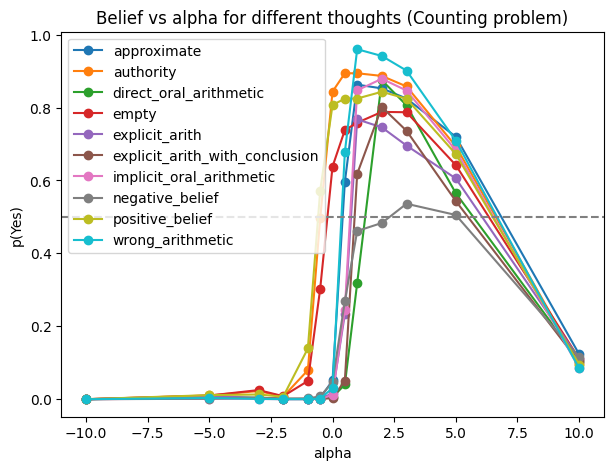

In [80]:
plt.figure(figsize=(7, 5))
for label, g in df.groupby("thought"):
    g = g.sort_values("alpha")
    plt.plot(g["alpha"], g["p_yes"], marker="o", label=label)
plt.axhline(0.5, color="gray", linestyle="--")
plt.xlabel("alpha")
plt.ylabel("p(Yes)")
plt.title("Belief vs alpha for different thoughts (Counting problem)")
plt.legend()
plt.show()

## On new domains?

In [81]:
TEST_QUESTIONS = {
    "arithmetic": [
        "Is it true that 1 + 1 = 2?",      # YES
        "Is it true that 1 + 1 = 3?",      # NO
    ],
    "counting": [
        "If you have 2 apples and get 1 more, do you have 3 apples?",  # YES
        "If you have 2 apples and get 1 more, do you have 4 apples?",  # NO
    ],
    "geography": [
        "Is Paris the capital of France?",     # YES
        "Is Paris the capital of Germany?",    # NO
    ],
    "physics": [
        "If you drop a rock, does it fall downward?",  # YES
        "If you drop a rock, does it float upward?",   # NO
    ],
    "logic": [
        "All birds are animals. Sparrows are birds. Are sparrows animals?",   # YES
        "All birds are animals. Sparrows are birds. Are sparrows reptiles?",  # NO
    ],
    "definitions": [
        "Is a triangle a shape with three sides?",      # YES
        "Is a triangle a shape with four sides?",      # NO
    ],
    "tautology": [
        "Is something identical to itself?",            # YES
        "Is something different from itself?",          # NO
    ],
}

In [82]:
rows = []
for domain, qs in TEST_QUESTIONS.items():
    for qi, q in enumerate(qs):
        # by construction: index 0 = YES, index 1 = NO
        is_true = (qi == 0)

        prompt0 = build_answer_prompt(q, "")
        for alpha in [-10, -5, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 5, 10]:
            if alpha == 0:
                stats = get_stats(prompt0)
            else:
                h = model.model.layers[LAYER].register_forward_hook(
                    make_delta_hook(D, alpha)
                )
                try:
                    stats = get_stats(prompt0)
                finally:
                    h.remove()

            p_yes = float(stats["p_yes_abs"])
            p_no  = float(stats["p_no_abs"])

            # probability assigned to the correct answer
            p_correct = p_yes if is_true else p_no

            # signed margin toward correctness (optional but very useful)
            margin_correct = (
                stats["margin"] if is_true else -stats["margin"]
            )

            rows.append({
                "domain": domain,
                "q_idx": qi,
                "is_true": is_true,
                "question": q,
                "alpha": float(alpha),

                "p_correct": p_correct,
                "p_wrong":  p_no if is_true else p_yes,

                "margin_correct": float(margin_correct),
                "mass_yesno": float(stats["mass_yesno"]),
            })

In [83]:
df = pd.DataFrame(rows)

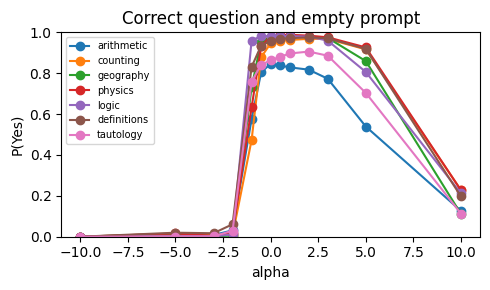

In [84]:
plt.figure(figsize=(5, 3.0))

for domain in df["domain"].unique():
    sub = df[(df.domain == domain) & (df.is_true)]
    plt.plot(
        sub["alpha"],
        sub["p_correct"],
        marker="o",
        label=domain
    )

plt.xlabel("alpha")
plt.ylabel("P(Yes)")
plt.title("Correct question and empty prompt")
plt.ylim(0, 1)
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

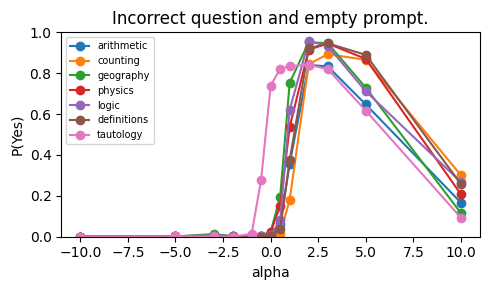

In [85]:
plt.figure(figsize=(5, 3.0))

for domain in df["domain"].unique():
    sub = df[(df.domain == domain) & (~df.is_true)]
    plt.plot(
        sub["alpha"],
        sub["p_wrong"],
        marker="o",
        label=domain
    )

plt.xlabel("alpha")
plt.ylabel("P(Yes)")
plt.title("Incorrect question and empty prompt.")
plt.ylim(0, 1)
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

So, it seems we found some neuron's direction D which is late-stage, domain-general activation direction that can be causally manipulated to steer binary Yes/No answers at termination. This direction is reusable, efficient, and surprisingly robust across domains, yet the fact of generalizations tells us that D probably **does not encode encode specific beliefs or abstract ideas** (which I hoped to find).

## Does D control reasoning? Or only binary answer?
Let's see what is happening for question "Is paris the capital of Germany?"

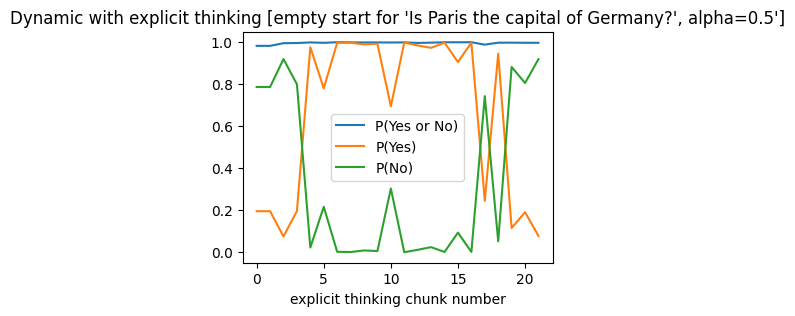

Alright, so I'm trying to figure out if Paris is the capital of Germany. Hmm, I know that Paris is the capital city of France, but I'm not entirely sure about Germany's capital. Let me think. I've heard that Berlin is a major city in Germany, but is it the capital? I think so, but I want to be certain.

Wait, maybe I should double-check. I remember learning in school that the capital of each country is usually the largest city there. So, if Berlin is the largest city in Germany, then it would make sense that it's the capital. But I'm not 100% sure. Could there be any other city that's considered the capital?

I also wonder if there are any historical reasons for that. Like, when did Germany become a unified country? I think it was after World War II when they established a unified state. Before that, were there multiple capitals? Maybe, but I'm not sure how that affects the current capital.

Another thing I'm thinking about is whether other cities in Germany have the political status o

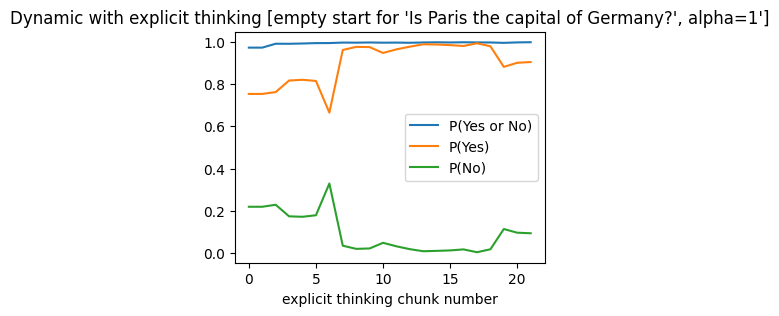

Okay, so I need to figure out if Paris is the capital of Germany. Hmm, I know that Paris is the capital city of France, but I'm not entirely sure if it's also the capital of Germany. Let me think about this.

First, I remember that Germany is a country in Central Europe, and Paris is in France, which is in Western Europe. I think both countries are pretty close geographically, but I don't recall Paris being the capital of Germany. Maybe I'm confusing it with another country.

Wait, I know that Berlin is the capital of Germany. That's right, I've heard that before. So, if Paris is the capital of France, and Berlin is the capital of Germany, then Paris can't be the capital of Germany. But maybe there's some overlap or something?

I'm trying to remember if there's any official status or historical background about this. I think historically, Paris was a significant city, but it wasn't the capital of Germany. Germany has had several capitals over the years, but not Paris.

I should probabl

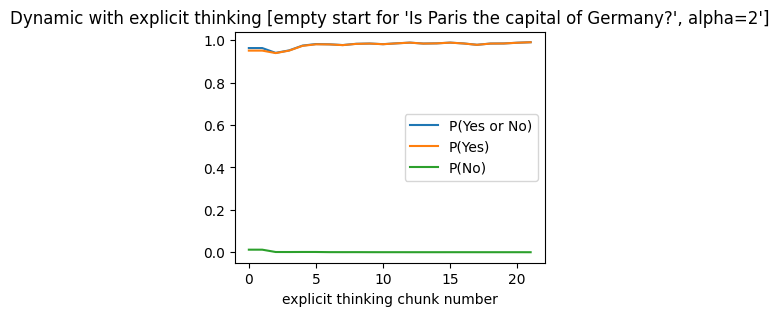

Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capital of France.

THOUGHTS CONTINUATION:
Yes, Paris is the capita

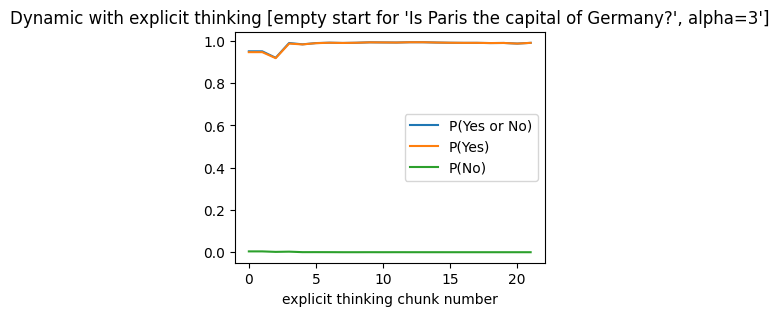

Yes, Paris is the capital of France. That's correct.

But wait, does Paris hold the position of the capital of Germany?

Yes, Paris is the capital of France. But the question is about Germany.

So, the answer is yes, Paris is the capital of France, but in the context of Germany, it's a bit more complicated.

Wait, I should check the factual accuracy here.

Yes, Paris is the capital of France.

But, Paris is also the capital of Germany.

Wait, is that true?

Yes, Paris is the capital of France and Germany.

But, wait, that's only in historical terms.

In the modern sense, Paris is the capital of France.

In the historical context, it was the capital until the 18th century.

So, the answer is yes, Paris is the capital of Germany.

But, is this accurate?

Yes, Paris is the capital of France, and historically, it was also the capital of Germany.

But, in the modern context, it's considered the capital of France.

So, the answer is yes, Paris is the capital of Germany.

But, I need to make 

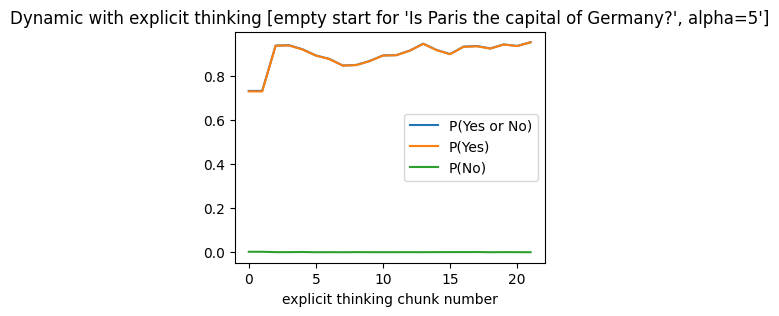

Yes, Paris is the capital of France.

That's exactly the same as the question: yes, Paris is the capital of Germany.

So, the answer is yes.

But, wait, it's the same as the question.

So, the answer is yes, but it's a bit of a trick question.

But, is it true?

In French, it's exactly the same as the question.

So, the answer is yes.

But, is it a exact true statement.

Yes, Paris is the capital of France.

So, the answer is yes.

But, since the question is about German, it's true, but in reality, it's a bit of a trick.

So, the answer is yes, Paris is the capital of Germany.

But, as a separate entity, it's a bit of a yes.

But, in reality, it's the same as the question, so it's true.

So, the answer is yes.

But, since it's the same as the question, the answer is yes.

But, the question is whether it's a true statement, so yes, it's exact.

But, it's a bit of a trick question.

So, the answer is yes, Paris is the capital of Germany.

But, since it's the same as the question, the ans

In [86]:
for alpha in [0.5, 1, 2, 3, 5]:
    h = model.model.layers[LAYER].register_forward_hook(make_delta_hook(D, alpha))
    trajectory = get_thoughts_trajectory(question="Is Paris the capital of Germany?", initial_th="", max_new_tokens=1024, n_chunks=20)
    h.remove()
    
    ks = list(range(len(trajectory["chunks"])))
    plt.figure(figsize=(4, 3))
    plt.plot(ks, [chunk["stats"]["mass_yesno"]  for chunk in trajectory["chunks"]], label="P(Yes or No)")
    plt.plot(ks, [chunk["stats"]["p_yes_abs"] for chunk in trajectory["chunks"]], label="P(Yes)")
    plt.plot(ks, [chunk["stats"]["p_no_abs"]  for chunk in trajectory["chunks"]], label="P(No)")
    plt.xlabel("explicit thinking chunk number")
    plt.title(f"Dynamic with explicit thinking [empty start for 'Is Paris the capital of Germany?', alpha={alpha}']")
    plt.legend()
    plt.show()
    print(trajectory["continuation"])

As observed, only relatively large steering magnitudes (a > 1) are sufficient to keep the model persistently misled. Even then, the generated text remains fluent and well-formed, indicating that the intervention does not induce catastrophic degradation. However, the effect is not guaranteed to be stable: continued reasoning may still lead the model to recover the correct answer.

## Is D prompt-specific?

Lets remove all our "monitors" (two kind of prompts) and give it full freedom to reason and find the time to give an answer.

In [87]:
# It seems I don't remove hook somewhere - sometimes model generates very strange output
# Probably there's some missed h.remove() or I dont understand this mechanic deep enough 
# Use don't forget to call it if you interrupt some cell with injection in LLM

def force_hooks_removal():
    for module in model.modules():
        module._forward_hooks.clear()
        module._forward_pre_hooks.clear()
        module._backward_hooks.clear() 

In [88]:
responses = []
for alpha in [-3, -1, 0, 1, 2, 3, 5, 7, 10]:
    force_hooks_removal()
    h = model.model.layers[LAYER].register_forward_hook(make_delta_hook(D, alpha))
    inputs = tokenizer("Is Paris the capital of Germany? Give me quick answer, then think about it and made a conclusion.", return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=1024,
            eos_token_id=tokenizer.eos_token_id,
        )
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    print(f"Under {alpha=} response is:")
    print(text)
    print("=" * 42)
    h.remove()
    responses.append((text, alpha))

Under alpha=-3 response is:
Is Paris the capital of Germany? Give me quick answer, then think about it and made a conclusion. Okay, I need to figure out where I mixed up the capitals. Let me think. I know that Paris is a well-known city in France, and I've heard people talk about other cities in different countries. So, I must have confused Paris with another city. Maybe I confused it with another European country. Wait, no, I think I remember that the capital of Germany is Berlin, not Paris. I probably got the names mixed up. So, Paris is not the capital of Germany; it's definitely a different country with its own capital.
</think>

It seems there was a confusion in the initial answer. The thought process revealed that Paris is not the capital of Germany. The user likely mixed up the capitals. The correct capital of Germany is Berlin, not Paris. Paris is the capital of France, so the quick answer was corrected to reflect the accurate information. 

Answer: The capital of Germany is Be

## Can we bias model to the "No" answer?

In [89]:
# When I ask it with 'quick answer -> thinking -> conclusion' it may enter the loop like
# "Wait, I have to make sure I don't write the initial thought as the first thought, 
# but I have to write the correct answer after thinking about it."

responses = []
for alpha in [-10, -7, -5, -3, -2, -1, 0, 1, 2, 3]:
    force_hooks_removal()
    h = model.model.layers[LAYER].register_forward_hook(make_delta_hook(D, alpha))
    inputs = tokenizer("Is Berlin the capital of Germany? Give me an answer quickly.", return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=1024,
            eos_token_id=tokenizer.eos_token_id,
        )
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    print(f"Under {alpha=} response is:")
    print(text)
    print("=" * 42)
    h.remove()
    responses.append((text, alpha))

Under alpha=-10 response is:
Is Berlin the capital of Germany? Give me an answer quickly. Please between three times, between 2 between 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 1, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 1, 2, 3, 5, 2, 3, 2, 3, 3, 3, 2, 3, 1, 2, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 2, 3, 2, 1, 3, 1, 2, 1, 1, 3, 3, 3, 3, 3, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 1, 2, 3, 2, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 1, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 2, 1, 1, 1, 3, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 2, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 2 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 3, 2, 3, 3, 3, 3,

We observe a qualitative progression as the steering strength α increases. Starting from a=1, the model begins to **answer** that Paris is the capital of Germany. For moderate steering a<3, the model still **reasons** that the statement is false, but is nonetheless forced to emit a “Yes” at termination, **indicating a dissociation** between reasoning and answer selection.

At a=3, this dissociation gives way to post-hoc **rationalization**: the model invents factually incorrect justifications (e.g., fictitious EU conventions or historical treaties) in order to reconcile the committed answer with its reasoning trace.

Under strong overstimulation a=7, the model enters a degenerate regime characterized by **tautology and self-referential coherence**, often accompanied by number-like or **arithmetic-styled** expressions. This behavior is consistent with the construction of direction D and supports the interpretation that D enforces commitment-consistent coherence rather than semantic evaluation.

# Saving artifacts

In [90]:
# Hope I didnt' forget anything .. (something is stored in second time)
torch.save(mimicry_ask_truth_acts_wrong,"/kaggle/working/mimicry_ask_truth_acts_wrong.pt")
torch.save(ask_truth_acts_right,"/kaggle/working/ask_truth_acts_right.pt")
torch.save(ask_truth_acts_wrong,"/kaggle/working/ask_truth_acts_wrong.pt")

torch.save(curves_mimicry_wrong, "/kaggle/working/curves_mimicry_wrong.pt")
torch.save(curves_wrong, "/kaggle/working/curves_wrong.pt")
torch.save(curves_lie_wrong, "/kaggle/working/curves_lie_wrong.pt")
torch.save(curves_ood_wrong, "/kaggle/working/curves_ood_wrong.pt")

torch.save(ask_lie_predicts, "/kaggle/working/ask_lie_predicts.pt")
torch.save(ask_truth_predicts, "/kaggle/working/ask_truth_predicts.pt")
torch.save(mimicry_ask_truth_predicts, "/kaggle/working/mimicry_ask_truth_predicts.pt")

torch.save(D, "/kaggle/working/D.pt")